## Rules to be followed when doing Time Series Forecasting:
1. Target data(ie the data you will forecast) should always be numerical data, cannot be categorical. It can be univariate or multivariate, but always numerical.
2. Missing data has to be imputed before performing Time series forecasting. You cannot drop the missing data because it will create empty spaces/breaks in the datetime sequence.
3. Date and time columns shold always be in sequence before you do the forecasting. Also datetime data should always be in ascending order.
4. Date and time datatype shpuld be convrted to datetime in the pre-processing step.
5. Always check whether the data has trend, seasonality and irregularity (noise) using visualization (DECOMPOSITION) methods before doing the predictions.


## Problem Statement and Agenda:

**One of the applications of Time Series Forecasting is to forecast the opening stock prices, closing stock prices, volume of stocks to be traded etc. In this data driven world, many firms are trying to forecast the future behaviour of the stock market. For this particular case study, we have the stock price data of Apple from the NASDAQ stock exchange for some time periods of 2018 through to 2019. We are going to divide our data into training and test, build our models on the training data, forecast for the test data time stamps and then evaluate using the Root Mean Squared Error (RMSE) model evaluation metric.**

**The following things will be covered in this case study:**
- Exploratory Data Analysis
- ARIMA/SARIMA models (with and without exogenous variables)


### 1. importing the necessary libraries 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode()
sns.set()
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from pylab import rcParams   # very good visualization package
from pandas import Series
from numpy import log


In [2]:
df = pd.read_csv('datasets_302666_618181_AAPL.csv')
df

Date        Open        High         Low       Close   Adj Close  \
0    8/15/2018  209.220001  210.740005  208.330002  210.240005  207.027420   
1    8/16/2018  211.750000  213.809998  211.470001  213.320007  210.060333   
2    8/17/2018  213.440002  217.949997  213.160004  217.580002  214.255234   
3    8/20/2018  218.100006  219.179993  215.110001  215.460007  212.167633   
4    8/21/2018  216.800003  217.190002  214.029999  215.039993  211.754028   
..         ...         ...         ...         ...         ...         ...   
246   8/8/2019  200.199997  203.529999  199.389999  203.429993  202.659988   
247   8/9/2019  201.300003  202.759995  199.289993  200.990005  200.990005   
248  8/12/2019  199.619995  202.050003  199.149994  200.479996  200.479996   
249  8/13/2019  201.020004  212.139999  200.479996  208.970001  208.970001   
250  8/14/2019  203.160004  206.440002  202.589996  202.750000  202.750000   

       Volume  
0    28807600  
1    28500400  
2    35427000  
3    30287700  
4    26159800  
..        ...  
246  27009500  
247  24619700  
248  22474900  
249  47218500  
250  36453100  

[251 rows x 7 columns]

In [3]:
from pandas.tseries.offsets import BDay
# this will handle the weekends s they are missing for business data. In case 
# you do not imort this packet, then what you will have to do is impute the 
# values for friday to Saturday and sunday after each week.

In [4]:
df.shape

(251, 7)

In [5]:
df_date = df[['Date', 'Volume']]

In [6]:
date1 = pd.date_range(start = '8/15/2018', end = '8/14/2019', freq = BDay())
# the end date you should put should be one day later than the data you have
# because python includes the start date and excludes the end date. 
# BUT WHEN YOU USE freq = BDay() then you can give the date as the last on 
# your data

In [7]:
date1

DatetimeIndex(['2018-08-15', '2018-08-16', '2018-08-17', '2018-08-20',
               '2018-08-21', '2018-08-22', '2018-08-23', '2018-08-24',
               '2018-08-27', '2018-08-28',
               ...
               '2019-08-01', '2019-08-02', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-12',
               '2019-08-13', '2019-08-14'],
              dtype='datetime64[ns]', length=261, freq='B')

In [8]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
us_bd

<CustomBusinessDay>

In [9]:
date = pd.date_range(start = '8/15/2018', end = '8/14/2019', freq = us_bd)
date

DatetimeIndex(['2018-08-15', '2018-08-16', '2018-08-17', '2018-08-20',
               '2018-08-21', '2018-08-22', '2018-08-23', '2018-08-24',
               '2018-08-27', '2018-08-28',
               ...
               '2019-08-01', '2019-08-02', '2019-08-05', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-12',
               '2019-08-13', '2019-08-14'],
              dtype='datetime64[ns]', length=251, freq='C')

In [10]:
df_date['Time_Stamp'] = pd.DataFrame(date, columns = ['Date'])
df_date

Date    Volume Time_Stamp
0    8/15/2018  28807600 2018-08-15
1    8/16/2018  28500400 2018-08-16
2    8/17/2018  35427000 2018-08-17
3    8/20/2018  30287700 2018-08-20
4    8/21/2018  26159800 2018-08-21
..         ...       ...        ...
246   8/8/2019  27009500 2019-08-08
247   8/9/2019  24619700 2019-08-09
248  8/12/2019  22474900 2019-08-12
249  8/13/2019  47218500 2019-08-13
250  8/14/2019  36453100 2019-08-14

[251 rows x 3 columns]

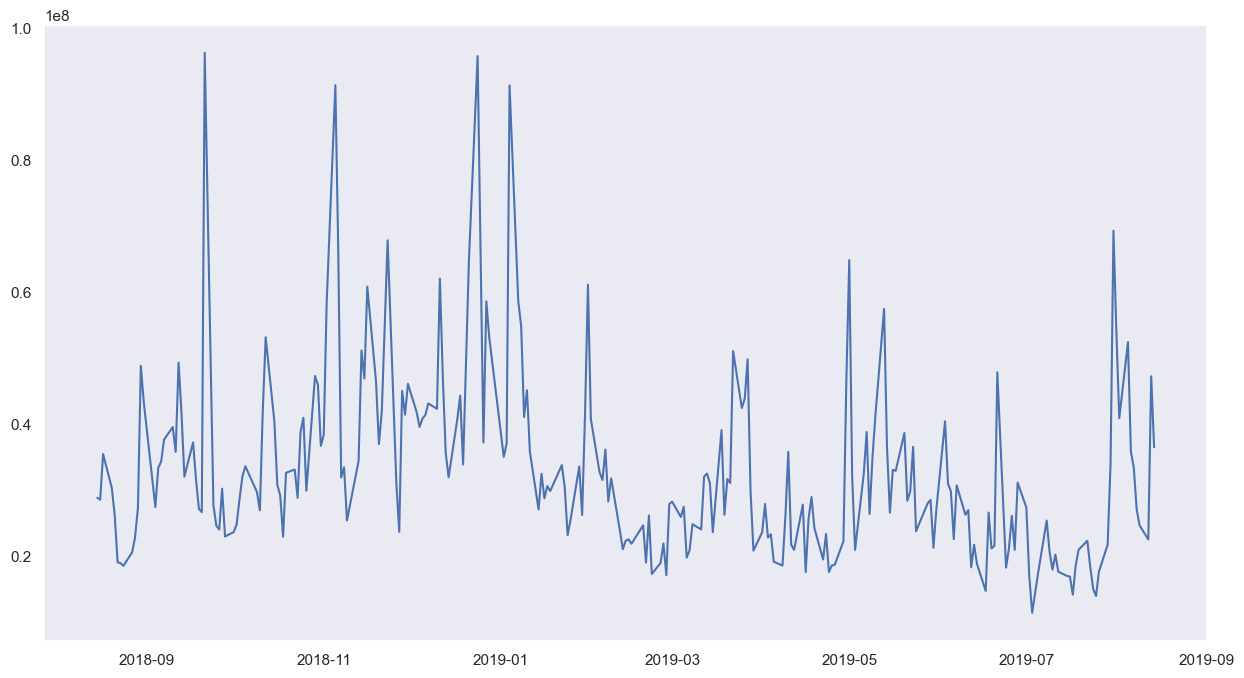

In [11]:
rcParams['figure.figsize'] = 15,8
plt.plot(df_date['Time_Stamp'], df_date['Volume']);
plt.grid()

In [12]:
df_date.describe()

Volume                     Time_Stamp
count  2.510000e+02                            251
mean   3.289967e+07  2019-02-14 07:56:10.517928192
min    1.136200e+07            2018-08-15 00:00:00
25%    2.329740e+07            2018-11-14 12:00:00
50%    2.985580e+07            2019-02-15 00:00:00
75%    3.927970e+07            2019-05-15 12:00:00
max    9.624670e+07            2019-08-14 00:00:00
std    1.385336e+07                            NaN

In [13]:
df_final = pd.read_csv('datasets_302666_618181_AAPL.csv', parse_dates = True, 
                       index_col = 0).squeeze()
# parse_dates means we are reading the data as Time Series data.
# squeeze = True means yes i want to transform my data (the one that is 
# independent) to the index column
# index_col = 0, give it the col number of the date in your data

In [14]:
df_final

Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-08-15  209.220001  210.740005  208.330002  210.240005  207.027420   
2018-08-16  211.750000  213.809998  211.470001  213.320007  210.060333   
2018-08-17  213.440002  217.949997  213.160004  217.580002  214.255234   
2018-08-20  218.100006  219.179993  215.110001  215.460007  212.167633   
2018-08-21  216.800003  217.190002  214.029999  215.039993  211.754028   
...                ...         ...         ...         ...         ...   
2019-08-08  200.199997  203.529999  199.389999  203.429993  202.659988   
2019-08-09  201.300003  202.759995  199.289993  200.990005  200.990005   
2019-08-12  199.619995  202.050003  199.149994  200.479996  200.479996   
2019-08-13  201.020004  212.139999  200.479996  208.970001  208.970001   
2019-08-14  203.160004  206.440002  202.589996  202.750000  202.750000   

              Volume  
Date                  
2018-08-15  28807600  
2018-08-16  28500400  
2018-08-17  35427000  
2018-08-20  30287700  
2018-08-21  26159800  
...              ...  
2019-08-08  27009500  
2019-08-09  24619700  
2019-08-12  22474900  
2019-08-13  47218500  
2019-08-14  36453100  

[251 rows x 6 columns]

In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-08-15 to 2019-08-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       251 non-null    float64
 1   High       251 non-null    float64
 2   Low        251 non-null    float64
 3   Close      251 non-null    float64
 4   Adj Close  251 non-null    float64
 5   Volume     251 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


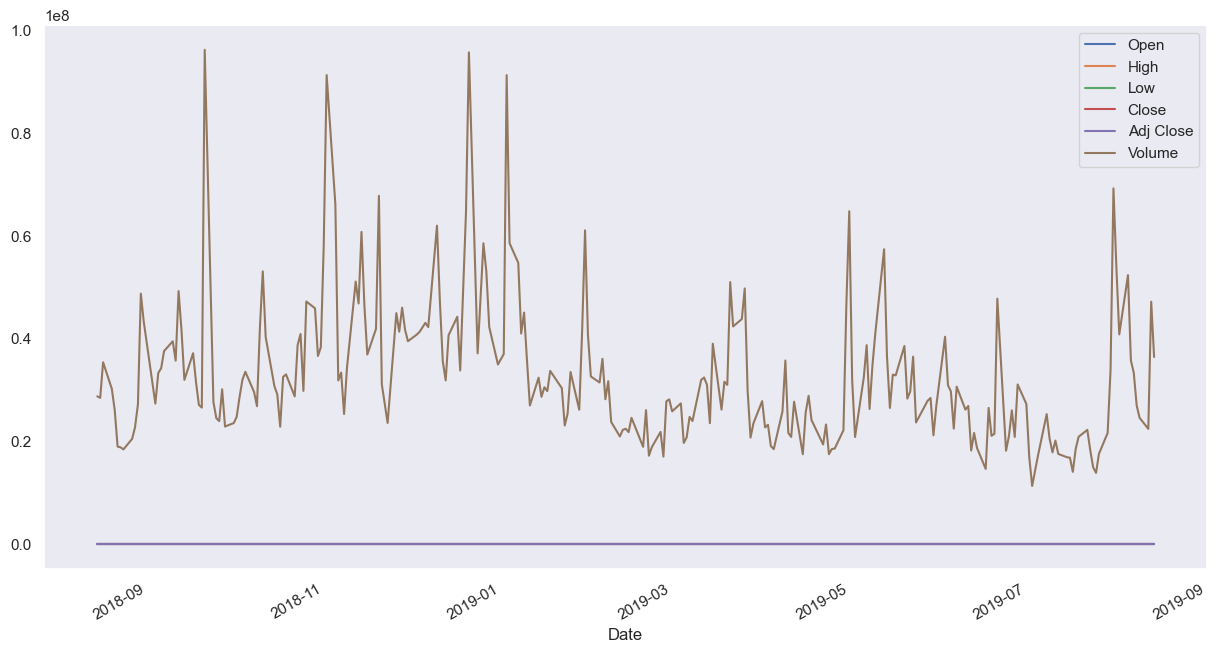

In [16]:
rcParams['figure.figsize'] = 15,8
df_final.plot();
plt.grid()

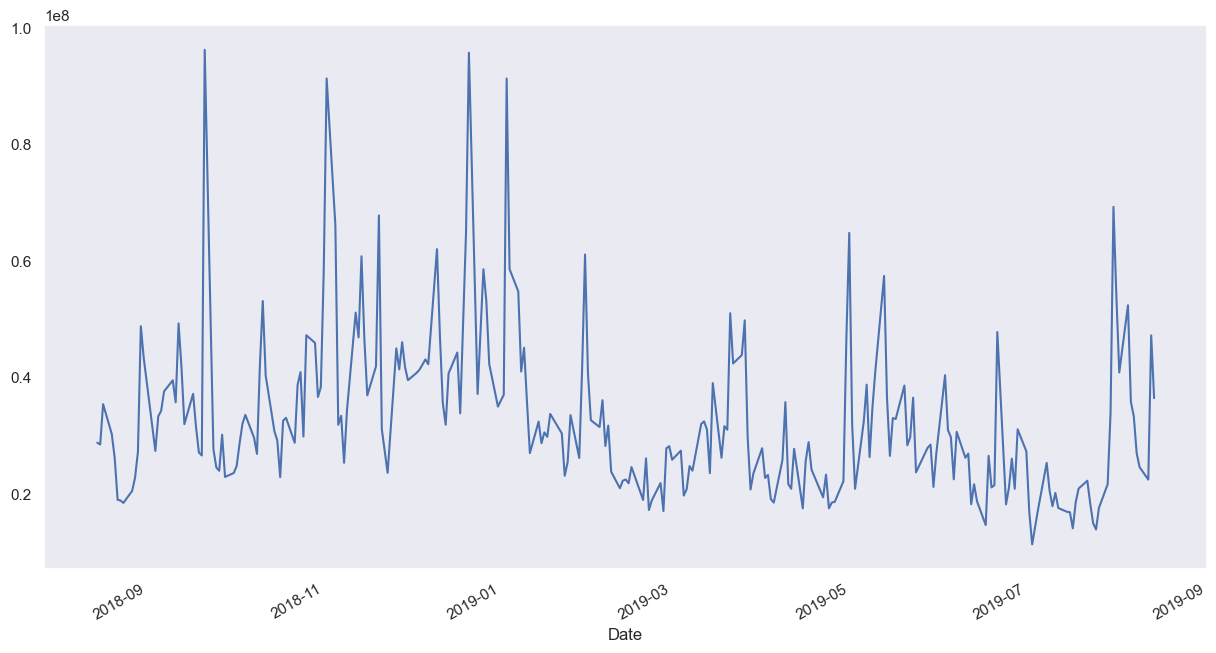

In [17]:
rcParams['figure.figsize'] = 15,8
df_final['Volume'].plot();
plt.grid()

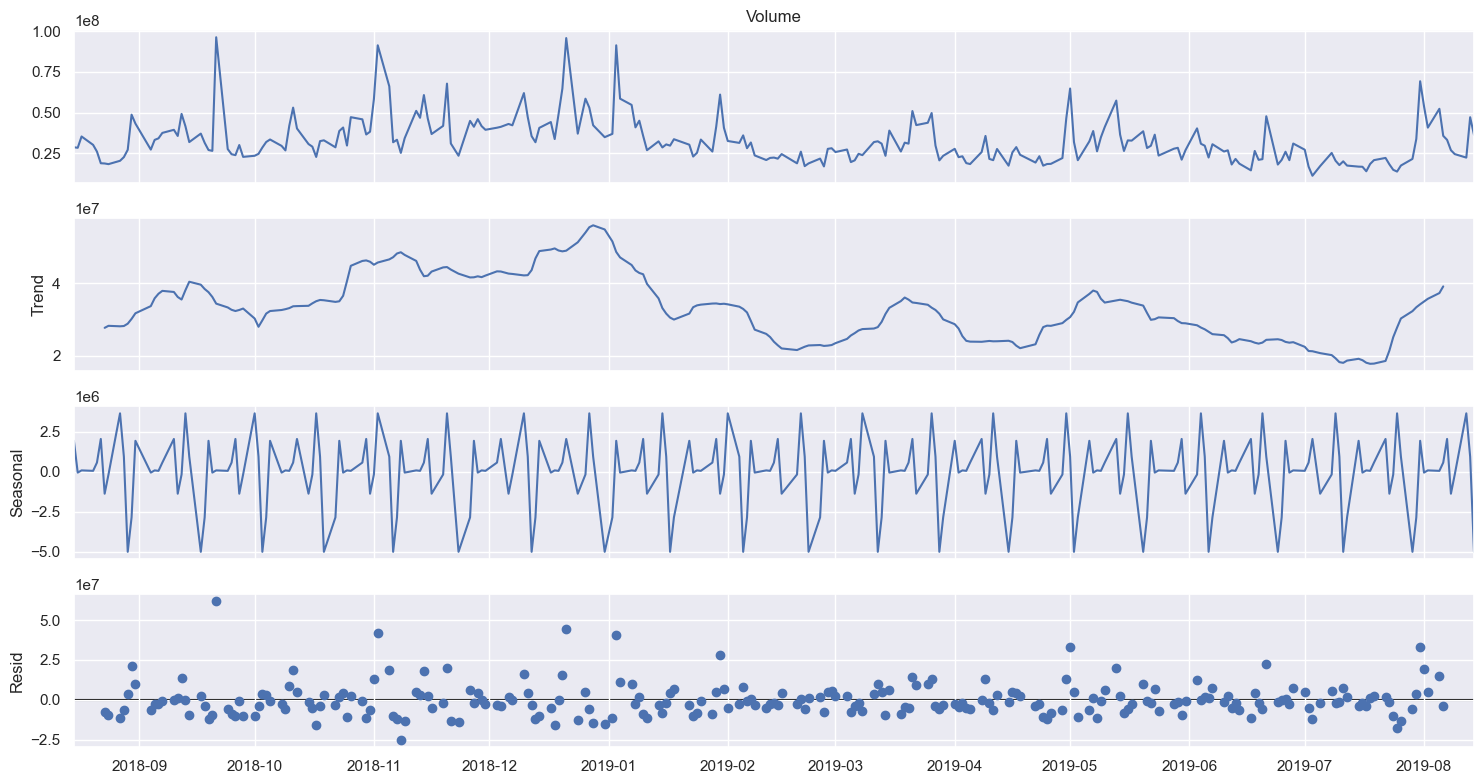

In [18]:
# DECOMPOSITION
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_final['Volume'], period = 12)
decomposition.plot()
plt.show()

In [19]:
import statsmodels.api as sm
sm.stats.durbin_watson(df_final['Volume'])
# highly positive auto-correlation

0.13804147049471416

## Plot the boxplot of the 'Open' variable wrt different years

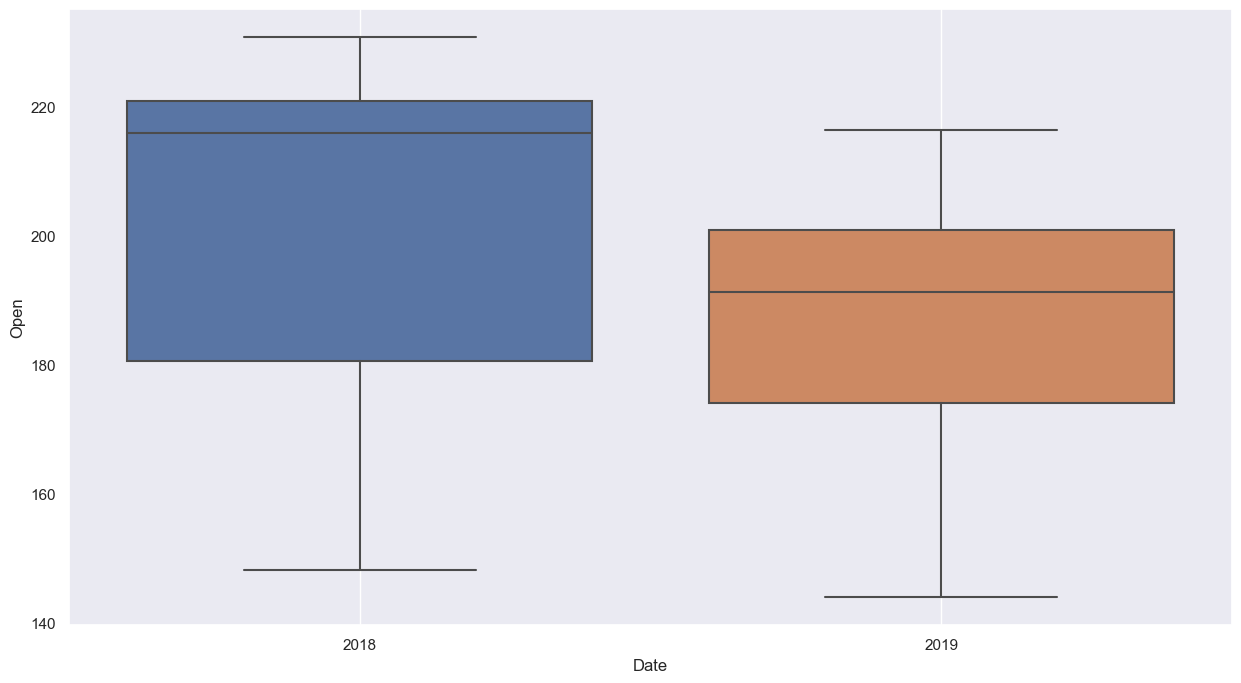

In [20]:
sns.boxplot(x = df_final.index.year, y =df_final['Open'])
plt.grid()

## Plot the boxplot of the 'Open' variable wrt different months

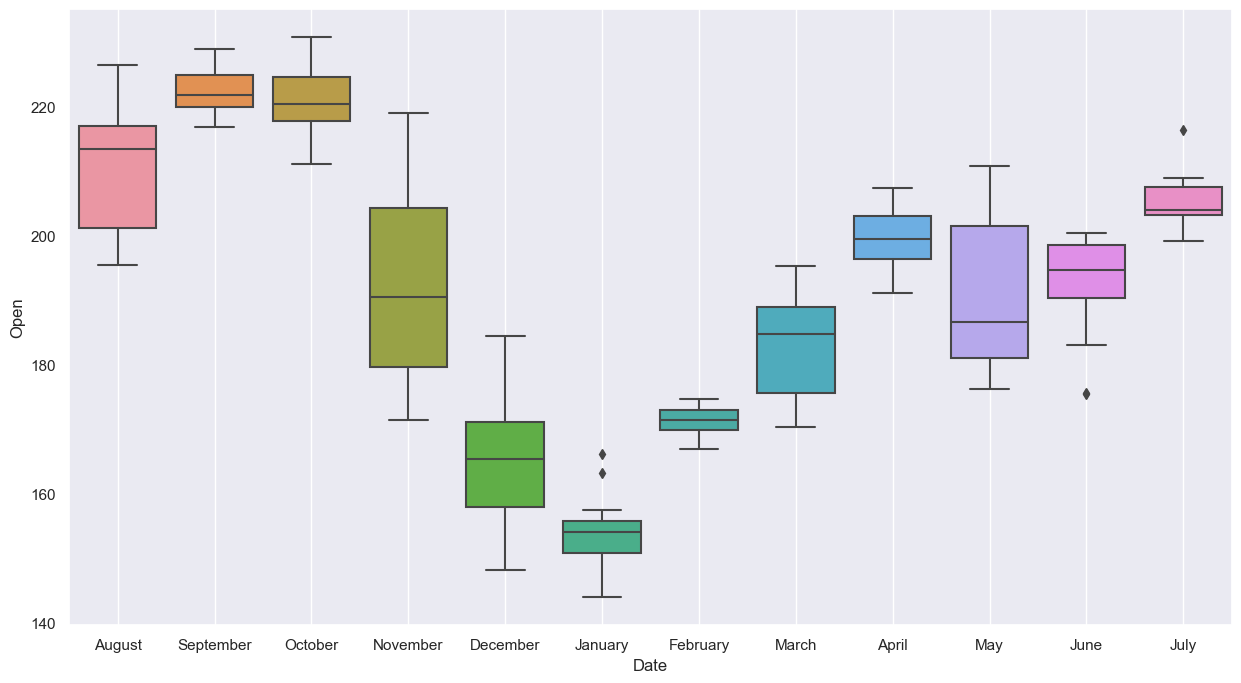

In [21]:
sns.boxplot(x = df_final.index.month_name(), y =df_final['Open'])
plt.grid()

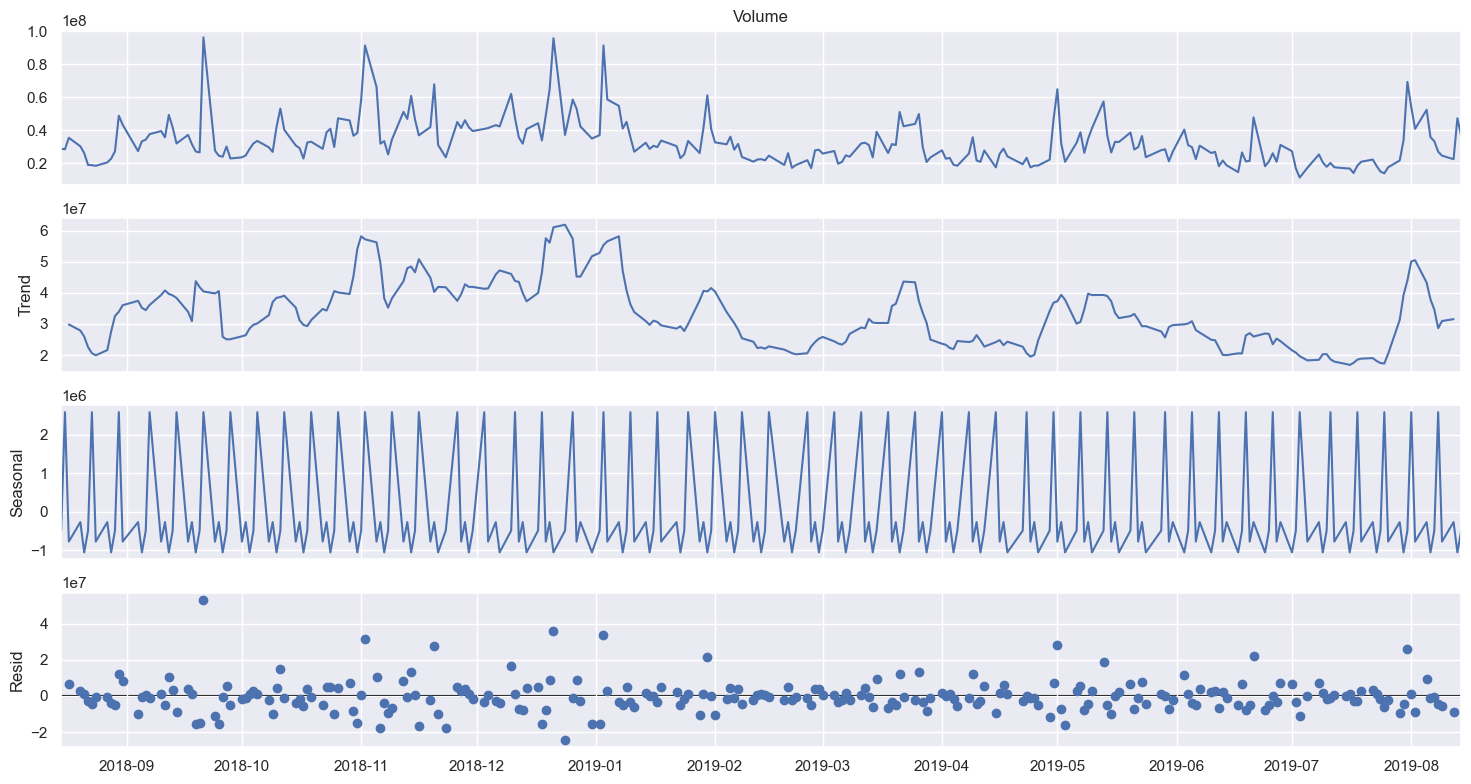

In [22]:
#period = 5 because we see that an increasing trend is there for four months
# then stable for the fifth month
decomposition = seasonal_decompose(df_final['Volume'], period = 5, 
                                   model = 'additive')
decomposition.plot()
plt.show()

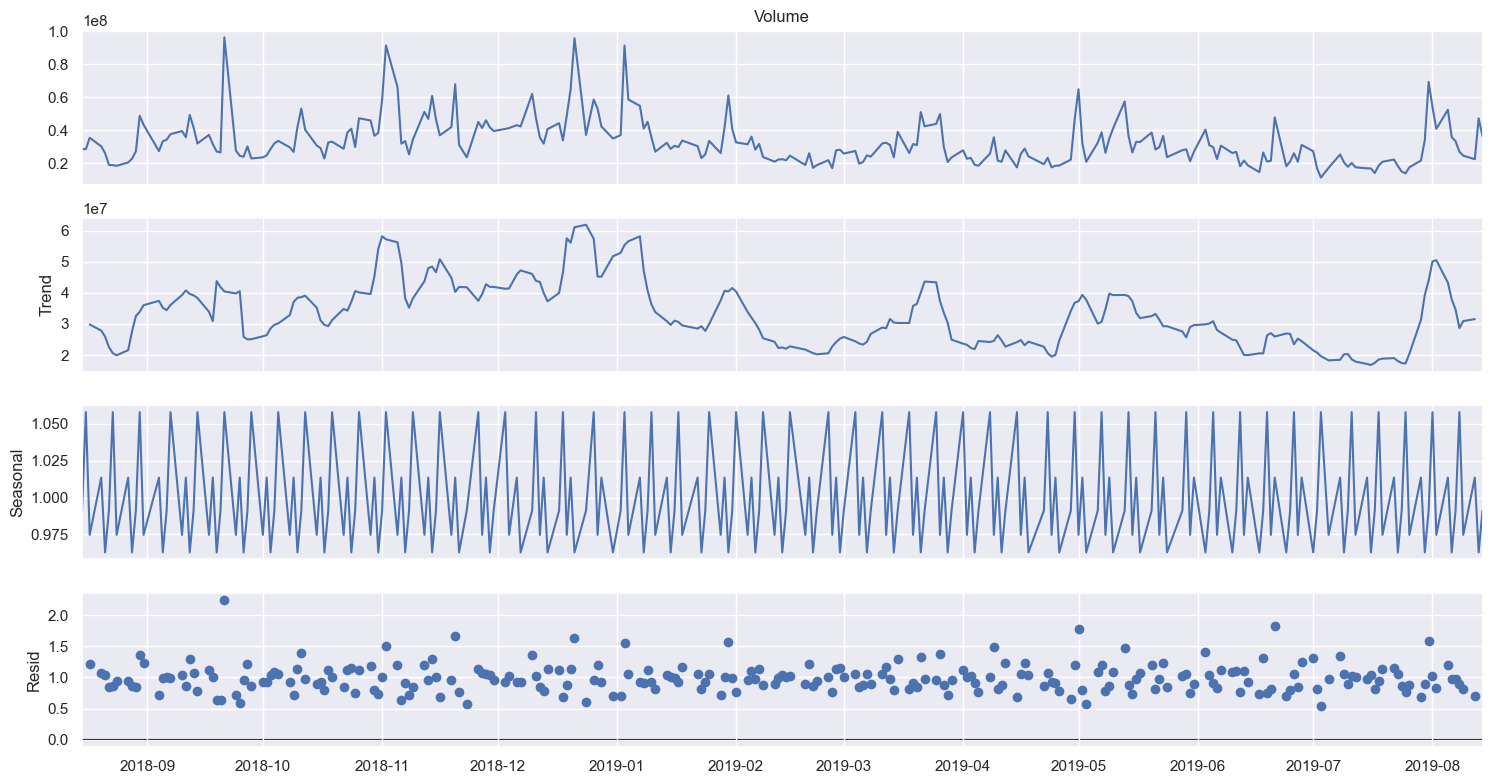

In [23]:
decomposition = seasonal_decompose(df_final['Volume'], period = 5, 
                                   model = 'multiplicative')
decomposition.plot()
plt.show()

## So series is Additive.

In [24]:
trend  = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend', '\n', trend.head(12), '\n')
print('Seasonality', '\n', seasonality.head(12), '\n')
print('Residual', '\n', residual.head(12), '\n')

Trend 
 Date
2018-08-15           NaN
2018-08-16           NaN
2018-08-17    29836500.0
2018-08-20    27878600.0
2018-08-21    25955160.0
2018-08-22    22565040.0
2018-08-23    20612520.0
2018-08-24    19935920.0
2018-08-27    21583260.0
2018-08-28    27565380.0
2018-08-29    32538120.0
2018-08-30    33911120.0
Name: trend, dtype: float64 

Seasonality 
 Date
2018-08-15    0.991134
2018-08-16    1.057854
2018-08-17    0.974697
2018-08-20    1.013504
2018-08-21    0.962811
2018-08-22    0.991134
2018-08-23    1.057854
2018-08-24    0.974697
2018-08-27    1.013504
2018-08-28    0.962811
2018-08-29    0.991134
2018-08-30    1.057854
Name: seasonal, dtype: float64 

Residual 
 Date
2018-08-15         NaN
2018-08-16         NaN
2018-08-17    1.218195
2018-08-20    1.071939
2018-08-21    1.046814
2018-08-22    0.850352
2018-08-23    0.866002
2018-08-24    0.950848
2018-08-27    0.938302
2018-08-28    0.858198
2018-08-29    0.845120
2018-08-30    1.360181
Name: resid, dtype: float64 



## split the data into training and testing before building the model

In [25]:
df.head()

Date        Open        High         Low       Close   Adj Close  \
0  8/15/2018  209.220001  210.740005  208.330002  210.240005  207.027420   
1  8/16/2018  211.750000  213.809998  211.470001  213.320007  210.060333   
2  8/17/2018  213.440002  217.949997  213.160004  217.580002  214.255234   
3  8/20/2018  218.100006  219.179993  215.110001  215.460007  212.167633   
4  8/21/2018  216.800003  217.190002  214.029999  215.039993  211.754028   

     Volume  
0  28807600  
1  28500400  
2  35427000  
3  30287700  
4  26159800

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [27]:
df['Time_Stamp'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        251 non-null    object        
 1   Open        251 non-null    float64       
 2   High        251 non-null    float64       
 3   Low         251 non-null    float64       
 4   Close       251 non-null    float64       
 5   Adj Close   251 non-null    float64       
 6   Volume      251 non-null    int64         
 7   Time_Stamp  251 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 15.8+ KB


In [28]:
df_final_model = df.set_index('Time_Stamp')

In [29]:
df_final_model

Date        Open        High         Low       Close  \
Time_Stamp                                                              
2018-08-15  8/15/2018  209.220001  210.740005  208.330002  210.240005   
2018-08-16  8/16/2018  211.750000  213.809998  211.470001  213.320007   
2018-08-17  8/17/2018  213.440002  217.949997  213.160004  217.580002   
2018-08-20  8/20/2018  218.100006  219.179993  215.110001  215.460007   
2018-08-21  8/21/2018  216.800003  217.190002  214.029999  215.039993   
...               ...         ...         ...         ...         ...   
2019-08-08   8/8/2019  200.199997  203.529999  199.389999  203.429993   
2019-08-09   8/9/2019  201.300003  202.759995  199.289993  200.990005   
2019-08-12  8/12/2019  199.619995  202.050003  199.149994  200.479996   
2019-08-13  8/13/2019  201.020004  212.139999  200.479996  208.970001   
2019-08-14  8/14/2019  203.160004  206.440002  202.589996  202.750000   

             Adj Close    Volume  
Time_Stamp                        
2018-08-15  207.027420  28807600  
2018-08-16  210.060333  28500400  
2018-08-17  214.255234  35427000  
2018-08-20  212.167633  30287700  
2018-08-21  211.754028  26159800  
...                ...       ...  
2019-08-08  202.659988  27009500  
2019-08-09  200.990005  24619700  
2019-08-12  200.479996  22474900  
2019-08-13  208.970001  47218500  
2019-08-14  202.750000  36453100  

[251 rows x 7 columns]

In [30]:
df_final_model['Month'] = df_final_model.index.month
df_final_model['Year'] = df_final_model.index.year
df_final_model.head()

Date        Open        High         Low       Close  \
Time_Stamp                                                              
2018-08-15  8/15/2018  209.220001  210.740005  208.330002  210.240005   
2018-08-16  8/16/2018  211.750000  213.809998  211.470001  213.320007   
2018-08-17  8/17/2018  213.440002  217.949997  213.160004  217.580002   
2018-08-20  8/20/2018  218.100006  219.179993  215.110001  215.460007   
2018-08-21  8/21/2018  216.800003  217.190002  214.029999  215.039993   

             Adj Close    Volume  Month  Year  
Time_Stamp                                     
2018-08-15  207.027420  28807600      8  2018  
2018-08-16  210.060333  28500400      8  2018  
2018-08-17  214.255234  35427000      8  2018  
2018-08-20  212.167633  30287700      8  2018  
2018-08-21  211.754028  26159800      8  2018

In [31]:
df_final_model.tail()

Date        Open        High         Low       Close  \
Time_Stamp                                                              
2019-08-08   8/8/2019  200.199997  203.529999  199.389999  203.429993   
2019-08-09   8/9/2019  201.300003  202.759995  199.289993  200.990005   
2019-08-12  8/12/2019  199.619995  202.050003  199.149994  200.479996   
2019-08-13  8/13/2019  201.020004  212.139999  200.479996  208.970001   
2019-08-14  8/14/2019  203.160004  206.440002  202.589996  202.750000   

             Adj Close    Volume  Month  Year  
Time_Stamp                                     
2019-08-08  202.659988  27009500      8  2019  
2019-08-09  200.990005  24619700      8  2019  
2019-08-12  200.479996  22474900      8  2019  
2019-08-13  208.970001  47218500      8  2019  
2019-08-14  202.750000  36453100      8  2019

In [32]:
train =df_final_model[pd.to_datetime(df_final_model['Date']) < pd.to_datetime('2019-06-14')]
train.shape

(208, 9)

In [33]:
test = df_final_model[pd.to_datetime(df_final_model['Date']) >= pd.to_datetime('2019-06-14')]
test.shape

(43, 9)

In [34]:
train_final = train[['Volume']]
test_final = test[['Volume']]

In [35]:
print(train_final.shape)
print(test_final.shape)

(208, 1)
(43, 1)


## Checking whether Time series is stationary at alpha = 0.05 using appropriate statistical tests.

In [36]:
from statsmodels.tsa.stattools import adfuller

In [37]:
# ONE Method : Augmented Dickey Fuller Test
# Another method : ROLLING STATISTICS

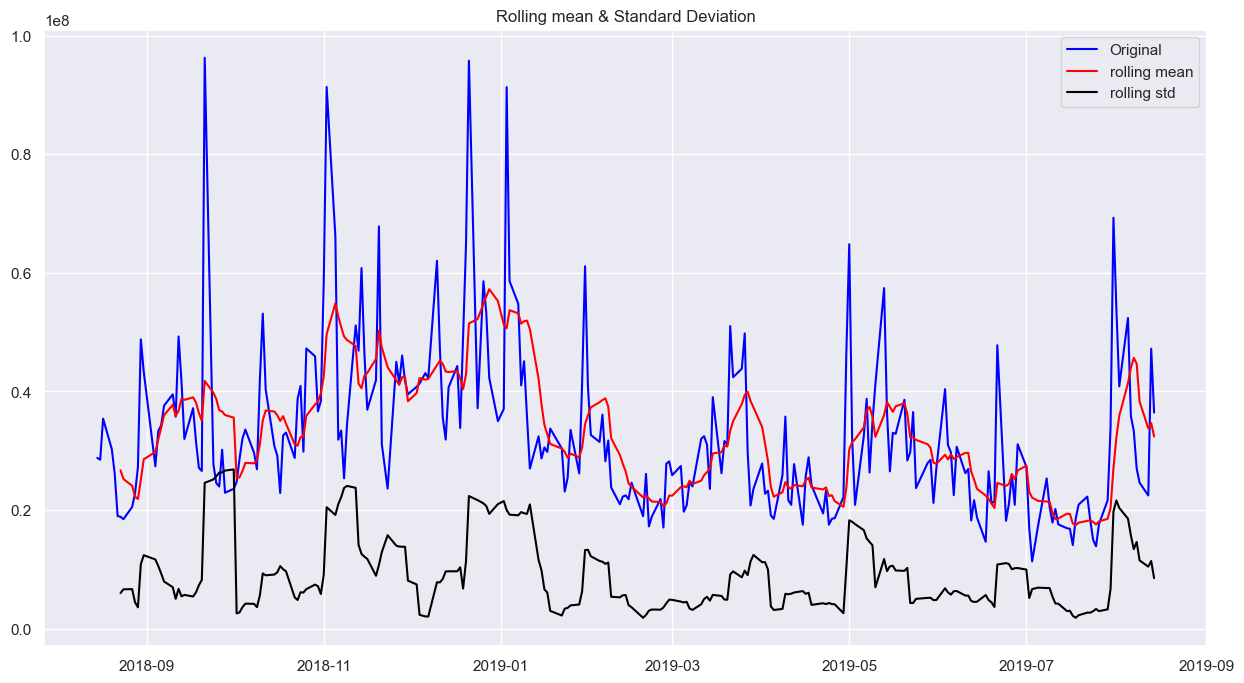

Augmented Dickey Fuller Test to check whether data is stationary or non-stationary
-----------------------------------------------------------------------------------
ADF Test Statistics : -3.2293023976274005
-----------
P-value : 0.018349972893812995
-----------
#Lags used : 6
-----------
No. of observations used : 244
-----------
Strong Evidence against Null Hypothesis and my timeseries is Stationary.


In [38]:
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(window = 7).mean()
    rolstd = timeseries.rolling(window = 7).std()
    
    # plot rolling statistics:
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'rolling mean')
    std = plt.plot(rolstd, color = 'black', label = 'rolling std')
    plt.legend(loc = 'best')
    plt.title('Rolling mean & Standard Deviation')
    plt.show(block = False)
    
    # performing Augmented Dickey Fuller Test
    print('Augmented Dickey Fuller Test to check whether data is stationary or non-stationary')
    print('-----------------------------------------------------------------------------------')
    adftest = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistics', 'P-value', '#Lags used', 'No. of observations used']
    
    for a, b in zip(adftest, labels):
        print(b + ' : '  + str(a))
        print('-----------')
        
    if adftest[1] <= 0.05:
        print('Strong Evidence against Null Hypothesis and my timeseries is Stationary.')
    else:
        print('Weak Evidence against Null Hypothesis and my timeseries is Non-Stationary')
        
    '''
    
    dfoutput = pd.Series(dftest[0:4], index = ['ADF Test Statistics', 'P-value', 
    '#Lags used', 'No. of observations used'])
    
    for key, value in adftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
    print(dfoutput,'\n')
    '''    
        
test_stationarity(df_final_model['Volume'])

## Series is stationary at 5% alpha as per ADF TEST

In [39]:
import itertools
p = q = range(0,3)
d = range(0,1) 
pdq = list(itertools.product(p,d,q))

model_pdq = [(x[0], x[1], x[2], 5) for x in pdq]
print('Examples of parameter combinations for model...')
print('Model : {}×{}'.format(pdq[1], model_pdq[1]))
print('Model : {}×{}'.format(pdq[2], model_pdq[2]))
print('Model : {}×{}'.format(pdq[3], model_pdq[3]))
print('Model : {}×{}'.format(pdq[4], model_pdq[4]))
print('Model : {}×{}'.format(pdq[5], model_pdq[5]))

Examples of parameter combinations for model...
Model : (0, 0, 1)×(0, 0, 1, 5)
Model : (0, 0, 2)×(0, 0, 2, 5)
Model : (1, 0, 0)×(1, 0, 0, 5)
Model : (1, 0, 1)×(1, 0, 1, 5)
Model : (1, 0, 2)×(1, 0, 2, 5)


## Building an ARIMA Model

In [57]:
# creating an empty dataframe with column names only

dfObj = pd.DataFrame(columns = ['param', 'AIC'])
dfObj

Empty DataFrame
Columns: [param, AIC]
Index: []

In [58]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    mod = ARIMA(train_final['Volume'], order = param)
    results_arima = mod.fit()
    print('ARIMA{} - AIC : {}'.format(param, results_arima.aic))
    dfObj = pd.concat([dfObj, pd.DataFrame({'param': [param], 'AIC': [results_arima.aic]})], ignore_index = True)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

ARIMA(0, 0, 0) - AIC : 8332.739978519614
ARIMA(0, 0, 1) - AIC : 7384.608245529029
ARIMA(0, 0, 2) - AIC : 7379.130340788781
ARIMA(1, 0, 0) - AIC : 7372.0748963861715
ARIMA(1, 0, 1) - AIC : 7373.194529993958
ARIMA(1, 0, 2) - AIC : 7366.068758423326
ARIMA(2, 0, 0) - AIC : 7373.701699527619


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

ARIMA(2, 0, 1) - AIC : 7367.221284404726
ARIMA(2, 0, 2) - AIC : 7367.9686586317575


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [59]:
dfObj.sort_values(by = ['AIC'])

param          AIC
5  (1, 0, 2)  7366.068758
7  (2, 0, 1)  7367.221284
8  (2, 0, 2)  7367.968659
3  (1, 0, 0)  7372.074896
4  (1, 0, 1)  7373.194530
6  (2, 0, 0)  7373.701700
2  (0, 0, 2)  7379.130341
1  (0, 0, 1)  7384.608246
0  (0, 0, 0)  8332.739979

In [60]:
# ARIMA is giving (1, 0, 2) as the lowest AIC : 7366.068758

mod = ARIMA(train_final['Volume'], order = (1, 0, 2))
results_arima = mod.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  208
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3678.034
Date:                Mon, 13 Jan 2025   AIC                           7366.069
Time:                        17:54:33   BIC                           7382.756
Sample:                             0   HQIC                          7372.816
                                - 208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.434e+07   3.04e-10   1.13e+17      0.000    3.43e+07    3.43e+07
ar.L1          0.9466      0.044     21.495      0.000       0.860       1.033
ma.L1         -0.5248      0.067     -7.841      0.0

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



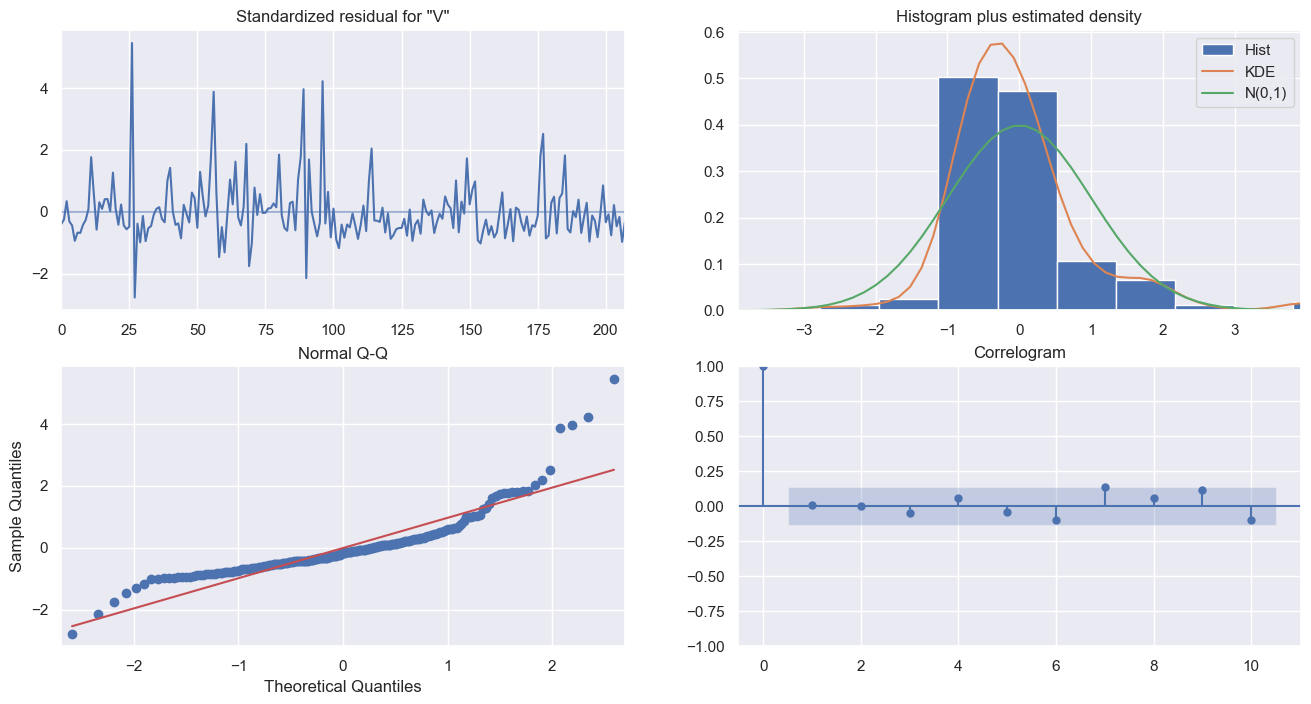

In [73]:
results_arima.plot_diagnostics(figsize = (16,8))
plt.show()

In [61]:
final_hat_avg = test_final.copy()
pred_ARIMA = results_arima.forecast(steps = len(test_final))
pred_ARIMA

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



208    2.732295e+07
209    2.869386e+07
210    2.899492e+07
211    2.927991e+07
212    2.954969e+07
213    2.980508e+07
214    3.004684e+07
215    3.027570e+07
216    3.049235e+07
217    3.069743e+07
218    3.089158e+07
219    3.107536e+07
220    3.124934e+07
221    3.141403e+07
222    3.156993e+07
223    3.171752e+07
224    3.185723e+07
225    3.198949e+07
226    3.211468e+07
227    3.223320e+07
228    3.234540e+07
229    3.245160e+07
230    3.255214e+07
231    3.264732e+07
232    3.273741e+07
233    3.282270e+07
234    3.290344e+07
235    3.297987e+07
236    3.305222e+07
237    3.312071e+07
238    3.318554e+07
239    3.324692e+07
240    3.330502e+07
241    3.336002e+07
242    3.341208e+07
243    3.346137e+07
244    3.350803e+07
245    3.355220e+07
246    3.359401e+07
247    3.363359e+07
248    3.367105e+07
249    3.370652e+07
250    3.374010e+07
Name: predicted_mean, dtype: float64

In [79]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = sqrt(mean_squared_error(test_final.Volume, pred_ARIMA, squared = False))
mape = mean_absolute_percentage_error(test_final.Volume, pred_ARIMA)

In [80]:
print(rmse)
print(mape)

3663.273005498899
0.5506203130745753


In [81]:
resultDF = pd.DataFrame({'Test RMSE': rmse, 'Test MAPE': mape}, index = ['ARIMA(1,0,2)'])
resultDF

Test RMSE  Test MAPE
ARIMA(1,0,2)  3663.273005    0.55062

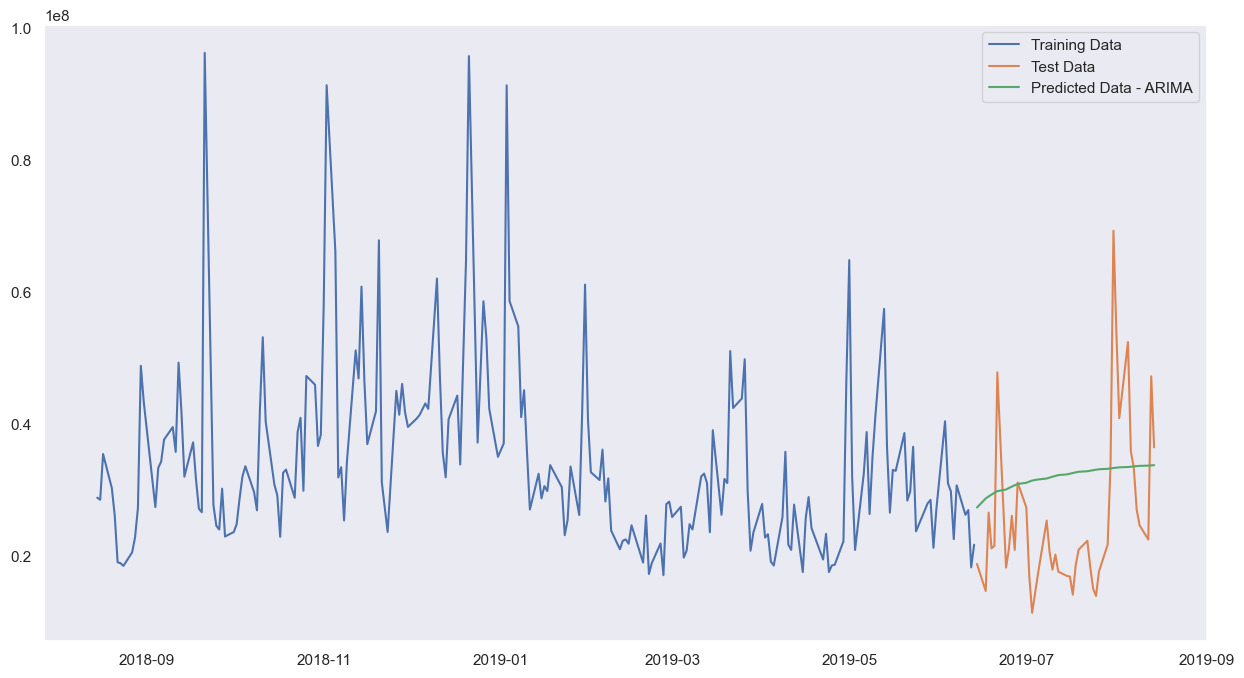

In [65]:
plt.plot(train_final, label = 'Training Data')
plt.plot(test_final, label = 'Test Data')
plt.plot(test_final.index, pred_ARIMA, label = 'Predicted Data - ARIMA')
plt.legend(loc='best')
plt.grid()

## Building a SARIMA model

In [67]:
dfObj2 = pd.DataFrame(columns = ['param', 'seasonal', 'AIC'])
dfObj2

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

In [68]:
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train_final['Volume'], order = param,
                                       seasonal_order = param_seasonal, 
                                       enforce_stationarity= False,
                                       enforce_invertibility= False)
        results_SARIMA = mod.fit()
        print('SARIMA{}×{}7 - AIC: {}'.format(param, param_seasonal, results_SARIMA.aic))
        dfObj2 = pd.concat([dfObj2, pd.DataFrame({'param': [param], 'seasonal' : [param_seasonal], 'AIC': [results_SARIMA.aic]})], ignore_index = True)
        

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(0, 0, 0)×(0, 0, 0, 5)7 - AIC: 7803.902158390863
SARIMA(0, 0, 0)×(0, 0, 1, 5)7 - AIC: 7516.843047531704
SARIMA(0, 0, 0)×(0, 0, 2, 5)7 - AIC: 7311.0144743144865
SARIMA(0, 0, 0)×(1, 0, 0, 5)7 - AIC: 7335.756112170122
SARIMA(0, 0, 0)×(1, 0, 1, 5)7 - AIC: 7240.848774197256


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 0)×(1, 0, 2, 5)7 - AIC: 7067.255496879531
SARIMA(0, 0, 0)×(2, 0, 0, 5)7 - AIC: 7120.87452132768
SARIMA(0, 0, 0)×(2, 0, 1, 5)7 - AIC: 7101.754037207327


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 0)×(2, 0, 2, 5)7 - AIC: 7069.848627478187
SARIMA(0, 0, 1)×(0, 0, 0, 5)7 - AIC: 7643.9036180653075
SARIMA(0, 0, 1)×(0, 0, 1, 5)7 - AIC: 7432.848224473457
SARIMA(0, 0, 1)×(0, 0, 2, 5)7 - AIC: 7241.978553953117


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(0, 0, 1)×(1, 0, 0, 5)7 - AIC: 7482.677398931115
SARIMA(0, 0, 1)×(1, 0, 1, 5)7 - AIC: 7401.246131356331
SARIMA(0, 0, 1)×(1, 0, 2, 5)7 - AIC: 7218.723683044126


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(0, 0, 1)×(2, 0, 0, 5)7 - AIC: 7295.3624889802195
SARIMA(0, 0, 1)×(2, 0, 1, 5)7 - AIC: 7293.113004755305


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 1)×(2, 0, 2, 5)7 - AIC: 7220.030979839197
SARIMA(0, 0, 2)×(0, 0, 0, 5)7 - AIC: 7579.195547009651
SARIMA(0, 0, 2)×(0, 0, 1, 5)7 - AIC: 7385.377098829446


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(0, 0, 2)×(0, 0, 2, 5)7 - AIC: 7200.696127783092
SARIMA(0, 0, 2)×(1, 0, 0, 5)7 - AIC: 7486.688579677626
SARIMA(0, 0, 2)×(1, 0, 1, 5)7 - AIC: 7368.855765239872


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(0, 0, 2)×(1, 0, 2, 5)7 - AIC: 7186.083308218642
SARIMA(0, 0, 2)×(2, 0, 0, 5)7 - AIC: 7299.850035871167


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(2, 0, 1, 5)7 - AIC: 7297.331773703529


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(2, 0, 2, 5)7 - AIC: 7187.372886617711
SARIMA(1, 0, 0)×(0, 0, 0, 5)7 - AIC: 7387.116568320252
SARIMA(1, 0, 0)×(0, 0, 1, 5)7 - AIC: 7215.043134007794
SARIMA(1, 0, 0)×(0, 0, 2, 5)7 - AIC: 7041.005271647404


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(1, 0, 0)×(1, 0, 0, 5)7 - AIC: 7215.058330973908
SARIMA(1, 0, 0)×(1, 0, 1, 5)7 - AIC: 7195.4420275790035


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 0)×(1, 0, 2, 5)7 - AIC: 7022.169522873035
SARIMA(1, 0, 0)×(2, 0, 0, 5)7 - AIC: 7040.797133692321


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 0)×(2, 0, 1, 5)7 - AIC: 7022.17715422171


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 0)×(2, 0, 2, 5)7 - AIC: 7023.007446131163
SARIMA(1, 0, 1)×(0, 0, 0, 5)7 - AIC: 7312.772230022076
SARIMA(1, 0, 1)×(0, 0, 1, 5)7 - AIC: 7137.525815354399


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(1, 0, 1)×(0, 0, 2, 5)7 - AIC: 6961.286618388656
SARIMA(1, 0, 1)×(1, 0, 0, 5)7 - AIC: 7173.04138786092


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(1, 0, 1, 5)7 - AIC: 7146.181150426537


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(1, 0, 2, 5)7 - AIC: 6969.473297817699
SARIMA(1, 0, 1)×(2, 0, 0, 5)7 - AIC: 7000.578933632829


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(2, 0, 1, 5)7 - AIC: 6998.987729924633


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(2, 0, 2, 5)7 - AIC: 6968.95537846801
SARIMA(1, 0, 2)×(0, 0, 0, 5)7 - AIC: 7263.706658558398


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(0, 0, 1, 5)7 - AIC: 7091.746463140502


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(0, 0, 2, 5)7 - AIC: 6914.849798961366


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(1, 0, 0, 5)7 - AIC: 7161.423940832394


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(1, 0, 1, 5)7 - AIC: 7104.688066618466


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(1, 0, 2, 5)7 - AIC: 6929.774699548676


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(2, 0, 0, 5)7 - AIC: 6989.311187855497


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(2, 0, 1, 5)7 - AIC: 6987.858384637471


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(2, 0, 2, 5)7 - AIC: 6924.302971650287
SARIMA(2, 0, 0)×(0, 0, 0, 5)7 - AIC: 7340.223467609073
SARIMA(2, 0, 0)×(0, 0, 1, 5)7 - AIC: 7202.27762275512


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(2, 0, 0)×(0, 0, 2, 5)7 - AIC: 7028.93367110103
SARIMA(2, 0, 0)×(1, 0, 0, 5)7 - AIC: 7167.83535150285


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(1, 0, 1, 5)7 - AIC: 7161.057783640952


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(1, 0, 2, 5)7 - AIC: 7022.512854877519
SARIMA(2, 0, 0)×(2, 0, 0, 5)7 - AIC: 6990.399041050346


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(2, 0, 1, 5)7 - AIC: 6982.574014114357


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(2, 0, 2, 5)7 - AIC: 6983.068932807853


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(0, 0, 0, 5)7 - AIC: 7766.209690856887
SARIMA(2, 0, 1)×(0, 0, 1, 5)7 - AIC: 7439.571545987196


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(0, 0, 2, 5)7 - AIC: 7218.868296108951


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(1, 0, 0, 5)7 - AIC: 7127.425961780509


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and 

SARIMA(2, 0, 1)×(1, 0, 1, 5)7 - AIC: 7129.41967522157
SARIMA(2, 0, 1)×(1, 0, 2, 5)7 - AIC: 6965.284752551297


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(2, 0, 0, 5)7 - AIC: 7032.859554907193


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(2, 0, 1, 5)7 - AIC: 6964.018596967528


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and 

SARIMA(2, 0, 1)×(2, 0, 2, 5)7 - AIC: 6960.369334565175
SARIMA(2, 0, 2)×(0, 0, 0, 5)7 - AIC: 7265.503125714997
SARIMA(2, 0, 2)×(0, 0, 1, 5)7 - AIC: 7092.752409703831


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(0, 0, 2, 5)7 - AIC: 6916.638345528464


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(1, 0, 0, 5)7 - AIC: 7127.911349481388


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(1, 0, 1, 5)7 - AIC: 7105.97798974527


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(1, 0, 2, 5)7 - AIC: 6931.614277902185


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(2, 0, 0, 5)7 - AIC: 6952.429104211441


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and 

SARIMA(2, 0, 2)×(2, 0, 1, 5)7 - AIC: 6953.654774976156
SARIMA(2, 0, 2)×(2, 0, 2, 5)7 - AIC: 6926.058660589873


In [69]:
dfObj2.sort_values(by = 'AIC')

param      seasonal          AIC
47  (1, 0, 2)  (0, 0, 2, 5)  6914.849799
74  (2, 0, 2)  (0, 0, 2, 5)  6916.638346
53  (1, 0, 2)  (2, 0, 2, 5)  6924.302972
80  (2, 0, 2)  (2, 0, 2, 5)  6926.058661
50  (1, 0, 2)  (1, 0, 2, 5)  6929.774700
..        ...           ...          ...
1   (0, 0, 0)  (0, 0, 1, 5)  7516.843048
18  (0, 0, 2)  (0, 0, 0, 5)  7579.195547
9   (0, 0, 1)  (0, 0, 0, 5)  7643.903618
63  (2, 0, 1)  (0, 0, 0, 5)  7766.209691
0   (0, 0, 0)  (0, 0, 0, 5)  7803.902158

[81 rows x 3 columns]

In [70]:
# (1, 0, 2)	(0, 0, 2, 5)	6914.849799
mod = sm.tsa.statespace.SARIMAX(train_final['Volume'], order = (1, 0, 2),
                                       seasonal_order = (0, 0, 2, 5), 
                                       enforce_stationarity= False,
                                       enforce_invertibility= False)
results_SARIMA = mod.fit()
print(results_SARIMA.summary())

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                  208
Model:             SARIMAX(1, 0, 2)x(0, 0, 2, 5)   Log Likelihood               -3451.425
Date:                           Wed, 15 Jan 2025   AIC                           6914.850
Time:                                   11:46:40   BIC                           6934.488
Sample:                                        0   HQIC                          6922.801
                                           - 208                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.004    225.754      0.000       0.990       1.007
ma.L1         -0.5661      0.056    -10.019

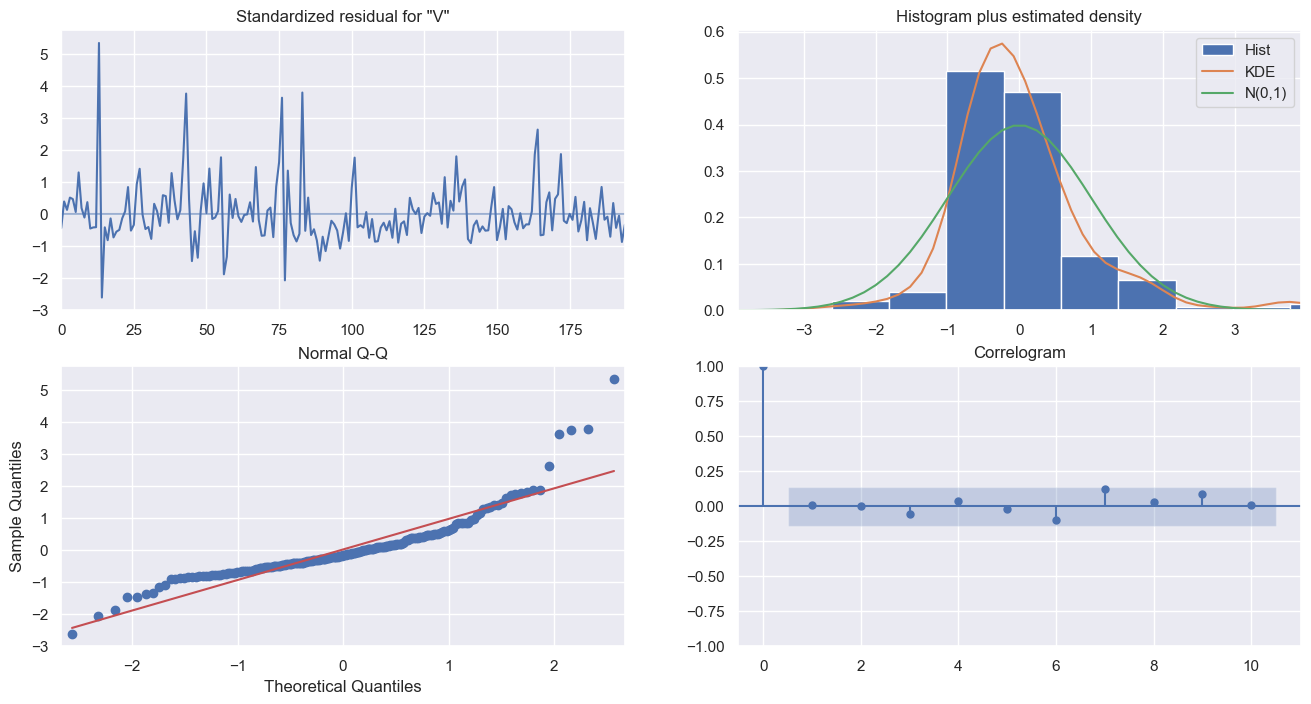

In [72]:
results_SARIMA.plot_diagnostics(figsize = (16,8))
plt.show()

In [74]:
final_hat_avg = test_final.copy()
pred_SARIMA = results_SARIMA.get_forecast(steps = len(test_final))
pred_SARIMA.predicted_mean

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



208    2.551438e+07
209    2.511371e+07
210    2.604882e+07
211    2.665580e+07
212    2.748681e+07
213    2.606189e+07
214    2.666892e+07
215    2.646157e+07
216    2.755252e+07
217    2.723942e+07
218    2.655785e+07
219    2.638261e+07
220    2.633986e+07
221    2.629718e+07
222    2.625457e+07
223    2.621202e+07
224    2.616955e+07
225    2.612715e+07
226    2.608481e+07
227    2.604254e+07
228    2.600034e+07
229    2.595821e+07
230    2.591615e+07
231    2.587416e+07
232    2.583223e+07
233    2.579037e+07
234    2.574858e+07
235    2.570686e+07
236    2.566521e+07
237    2.562362e+07
238    2.558210e+07
239    2.554065e+07
240    2.549926e+07
241    2.545794e+07
242    2.541669e+07
243    2.537551e+07
244    2.533439e+07
245    2.529334e+07
246    2.525235e+07
247    2.521143e+07
248    2.517058e+07
249    2.512980e+07
250    2.508908e+07
Name: predicted_mean, dtype: float64

In [82]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = sqrt(mean_squared_error(test_final.Volume, pred_SARIMA.predicted_mean,
                               squared = False))
mape = mean_absolute_percentage_error(test_final.Volume, 
                                      pred_SARIMA.predicted_mean)
print(rmse)
print()
print(mape * 100, '%' )

3547.6718651160486

38.118422889505325 %


In [84]:
resultDF = pd.concat([resultDF, pd.DataFrame({'Test RMSE': [rmse],
                                              'Test MAPE': [mape]},
                                        index = ['SARIMA(1,0,2)×(0,0,2,5)'])])
resultDF   

Test RMSE  Test MAPE
ARIMA(1,0,2)             3663.273005   0.550620
SARIMA(1,0,2)×(0,0,2,5)  3547.671865   0.381184

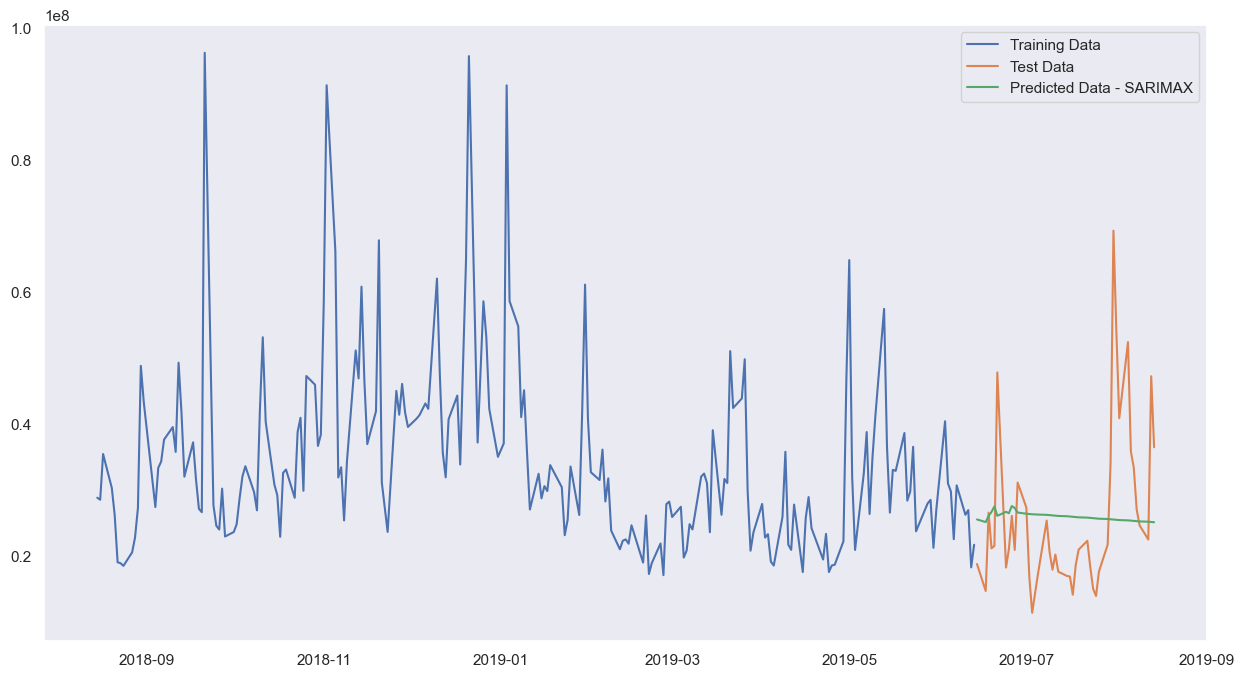

In [85]:
plt.plot(train_final, label = 'Training Data')
plt.plot(test_final, label = 'Test Data')
plt.plot(test_final.index, pred_SARIMA.predicted_mean, 
         label = 'Predicted Data - SARIMA')
plt.legend(loc='best')
plt.grid()

## Building a SARIMAX model

In [86]:
train.head()

Date        Open        High         Low       Close  \
Time_Stamp                                                              
2018-08-15  8/15/2018  209.220001  210.740005  208.330002  210.240005   
2018-08-16  8/16/2018  211.750000  213.809998  211.470001  213.320007   
2018-08-17  8/17/2018  213.440002  217.949997  213.160004  217.580002   
2018-08-20  8/20/2018  218.100006  219.179993  215.110001  215.460007   
2018-08-21  8/21/2018  216.800003  217.190002  214.029999  215.039993   

             Adj Close    Volume  Month  Year  
Time_Stamp                                     
2018-08-15  207.027420  28807600      8  2018  
2018-08-16  210.060333  28500400      8  2018  
2018-08-17  214.255234  35427000      8  2018  
2018-08-20  212.167633  30287700      8  2018  
2018-08-21  211.754028  26159800      8  2018

In [129]:
ex_train = train[['High', 'Low', 'Adj Close']]
ex_test = test[['High', 'Low', 'Adj Close']]
dfObj3 = pd.DataFrame(columns = ['param', 'seasonal_ex', 'AIC'])
dfObj3

Empty DataFrame
Columns: [param, seasonal_ex, AIC]
Index: []

In [130]:
# Let's first use SARIMAX with exogenous variabe
import statsmodels.api as sm
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train_final['Volume'], exog = ex_train,
                                       order = param,
                                       seasonal_order = param_seasonal, 
                                       enforce_stationarity= False,
                                       enforce_invertibility= False)
        results_SARIMA = mod.fit()
        print('SARIMA{}×{}7 - AIC: {}'.format(param, param_seasonal,
                                              results_SARIMA.aic))
        dfObj3 = pd.concat([dfObj3, pd.DataFrame({'param': [param], 
                                            'seasonal_ex' : [param_seasonal],
                                                'AIC': [results_SARIMA.aic]})],
                           ignore_index = True)     

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(0, 0, 0)×(0, 0, 0, 5)7 - AIC: 8220.966803816667
SARIMA(0, 0, 0)×(0, 0, 1, 5)7 - AIC: 7146.526550991197
SARIMA(0, 0, 0)×(0, 0, 2, 5)7 - AIC: 6972.976354840715
SARIMA(0, 0, 0)×(1, 0, 0, 5)7 - AIC: 7179.858613894294


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 0)×(1, 0, 1, 5)7 - AIC: 7138.987695164742
SARIMA(0, 0, 0)×(1, 0, 2, 5)7 - AIC: 6967.72752158613
SARIMA(0, 0, 0)×(2, 0, 0, 5)7 - AIC: 7004.7561885612395


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 0)×(2, 0, 1, 5)7 - AIC: 7001.9569958448055


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 0)×(2, 0, 2, 5)7 - AIC: 6961.809797552181
SARIMA(0, 0, 1)×(0, 0, 0, 5)7 - AIC: 7266.170910989799
SARIMA(0, 0, 1)×(0, 0, 1, 5)7 - AIC: 7092.459813353158


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(0, 0, 1)×(0, 0, 2, 5)7 - AIC: 6921.110851140698
SARIMA(0, 0, 1)×(1, 0, 0, 5)7 - AIC: 7161.530814296853


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 1)×(1, 0, 1, 5)7 - AIC: 7089.872393135229


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 1)×(1, 0, 2, 5)7 - AIC: 6919.064123880094
SARIMA(0, 0, 1)×(2, 0, 0, 5)7 - AIC: 6989.709618089713


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 1)×(2, 0, 1, 5)7 - AIC: 6988.541188376508


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 1)×(2, 0, 2, 5)7 - AIC: 6920.461817362777
SARIMA(0, 0, 2)×(0, 0, 0, 5)7 - AIC: 7227.944634272543


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(0, 0, 1, 5)7 - AIC: 7056.309820312657
SARIMA(0, 0, 2)×(0, 0, 2, 5)7 - AIC: 6884.146384932112


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(1, 0, 0, 5)7 - AIC: 7159.83828469523


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(1, 0, 1, 5)7 - AIC: 7054.616914989091


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(1, 0, 2, 5)7 - AIC: 6882.380846680458
SARIMA(0, 0, 2)×(2, 0, 0, 5)7 - AIC: 6988.507988216354


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(2, 0, 1, 5)7 - AIC: 6987.433775880324


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(0, 0, 2)×(2, 0, 2, 5)7 - AIC: 6884.80985079243
SARIMA(1, 0, 0)×(0, 0, 0, 5)7 - AIC: 7291.8764433545475
SARIMA(1, 0, 0)×(0, 0, 1, 5)7 - AIC: 7121.056440238832


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(1, 0, 0)×(0, 0, 2, 5)7 - AIC: 6950.755624860172
SARIMA(1, 0, 0)×(1, 0, 0, 5)7 - AIC: 7120.954889122979


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 0)×(1, 0, 1, 5)7 - AIC: 7119.763123249211


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 0)×(1, 0, 2, 5)7 - AIC: 6949.278047613251
SARIMA(1, 0, 0)×(2, 0, 0, 5)7 - AIC: 6950.493917792863


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 0)×(2, 0, 1, 5)7 - AIC: 6949.343262562051


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 0)×(2, 0, 2, 5)7 - AIC: 6950.939160370428
SARIMA(1, 0, 1)×(0, 0, 0, 5)7 - AIC: 7248.721617717132


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(0, 0, 1, 5)7 - AIC: 7076.5589677782245


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(0, 0, 2, 5)7 - AIC: 6906.580539727522


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(1, 0, 0, 5)7 - AIC: 7111.224125468307


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(1, 0, 1, 5)7 - AIC: 7078.499145419256


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(1, 0, 2, 5)7 - AIC: 6907.340187848897


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(2, 0, 0, 5)7 - AIC: 6941.014477034411


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(2, 0, 1, 5)7 - AIC: 6942.284587738745


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 1)×(2, 0, 2, 5)7 - AIC: 6899.0239629755
SARIMA(1, 0, 2)×(0, 0, 0, 5)7 - AIC: 7213.168730840724


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(0, 0, 1, 5)7 - AIC: 7042.09065013917


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(0, 0, 2, 5)7 - AIC: 6870.287803678989
SARIMA(1, 0, 2)×(1, 0, 0, 5)7 - AIC: 7110.925505483738


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(1, 0, 1, 5)7 - AIC: 7044.027745168052


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(1, 0, 2, 5)7 - AIC: 6871.437708557794


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(2, 0, 0, 5)7 - AIC: 6940.760586863756


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(2, 0, 1, 5)7 - AIC: 6943.142322912882


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(1, 0, 2)×(2, 0, 2, 5)7 - AIC: 6874.124442610302
SARIMA(2, 0, 0)×(0, 0, 0, 5)7 - AIC: 7255.750383394737
SARIMA(2, 0, 0)×(0, 0, 1, 5)7 - AIC: 7120.096164734332


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been prov

SARIMA(2, 0, 0)×(0, 0, 2, 5)7 - AIC: 6950.2443995052745
SARIMA(2, 0, 0)×(1, 0, 0, 5)7 - AIC: 7085.643910736479


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(1, 0, 1, 5)7 - AIC: 7085.234722776961


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(1, 0, 2, 5)7 - AIC: 6948.927667863485
SARIMA(2, 0, 0)×(2, 0, 0, 5)7 - AIC: 6915.6244623067105


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(2, 0, 1, 5)7 - AIC: 6914.598528128203


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 0)×(2, 0, 2, 5)7 - AIC: 6909.264006737529
SARIMA(2, 0, 1)×(0, 0, 0, 5)7 - AIC: 7247.608944352258


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(0, 0, 1, 5)7 - AIC: 7076.37907935443


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(0, 0, 2, 5)7 - AIC: 6906.268626471871


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(1, 0, 0, 5)7 - AIC: 7076.4171891453425


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(1, 0, 1, 5)7 - AIC: 7078.336257230292


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(1, 0, 2, 5)7 - AIC: 6907.343143469194


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(2, 0, 0, 5)7 - AIC: 6906.17411357145


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 1)×(2, 0, 1, 5)7 - AIC: 6907.23710643581


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and 

SARIMA(2, 0, 1)×(2, 0, 2, 5)7 - AIC: 6898.843906276484
SARIMA(2, 0, 2)×(0, 0, 0, 5)7 - AIC: 7215.163633895849


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(0, 0, 1, 5)7 - AIC: 7044.086317117467


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(0, 0, 2, 5)7 - AIC: 6872.284493873625


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(1, 0, 0, 5)7 - AIC: 7078.376140347463


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(1, 0, 1, 5)7 - AIC: 7046.024602397157


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(1, 0, 2, 5)7 - AIC: 6873.433314574852


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(2, 0, 0, 5)7 - AIC: 6908.084991713183


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(2, 0, 1, 5)7 - AIC: 6909.179292547822


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



SARIMA(2, 0, 2)×(2, 0, 2, 5)7 - AIC: 6876.123001545886


In [131]:
dfObj3.sort_values(by = 'AIC')

param   seasonal_ex          AIC
47  (1, 0, 2)  (0, 0, 2, 5)  6870.287804
50  (1, 0, 2)  (1, 0, 2, 5)  6871.437709
74  (2, 0, 2)  (0, 0, 2, 5)  6872.284494
77  (2, 0, 2)  (1, 0, 2, 5)  6873.433315
53  (1, 0, 2)  (2, 0, 2, 5)  6874.124443
..        ...           ...          ...
36  (1, 0, 1)  (0, 0, 0, 5)  7248.721618
54  (2, 0, 0)  (0, 0, 0, 5)  7255.750383
9   (0, 0, 1)  (0, 0, 0, 5)  7266.170911
27  (1, 0, 0)  (0, 0, 0, 5)  7291.876443
0   (0, 0, 0)  (0, 0, 0, 5)  8220.966804

[81 rows x 3 columns]

In [132]:
# (1, 0, 2)	(0, 0, 2, 5)	6870.287804

mod = sm.tsa.statespace.SARIMAX(train_final['Volume'], exog = ex_train,
                                       order = (1,0,2),
                                       seasonal_order = (0,0,2,5), 
                                       enforce_stationarity= False,
                                       enforce_invertibility= False)
results_SARIMA = mod.fit()

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [133]:
print(results_SARIMA.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                  208
Model:             SARIMAX(1, 0, 2)x(0, 0, 2, 5)   Log Likelihood               -3426.144
Date:                           Wed, 15 Jan 2025   AIC                           6870.288
Time:                                   13:03:48   BIC                           6899.745
Sample:                                        0   HQIC                          6882.215
                                           - 208                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High        5.139e+06   3.31e+05     15.544      0.000    4.49e+06    5.79e+06
Low        -4.488e+06    3.8e+04   -118.162

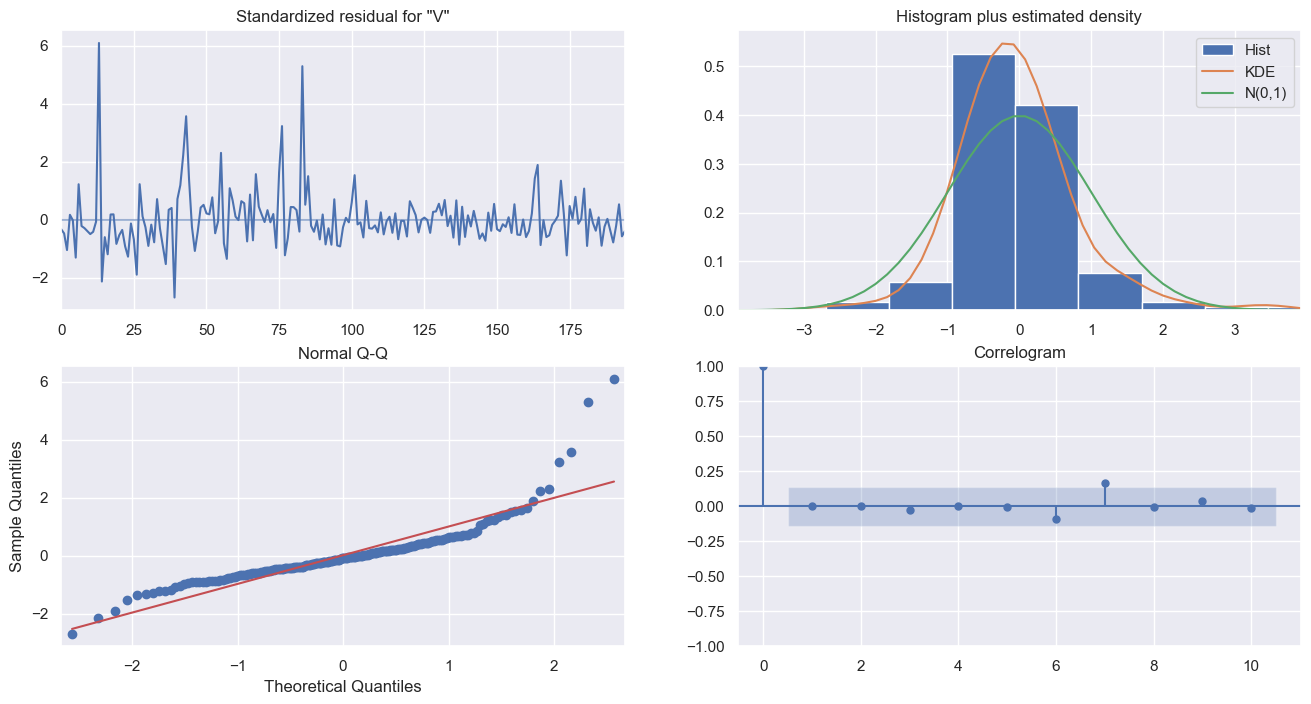

In [134]:
results_SARIMA.plot_diagnostics(figsize = (16,8))
plt.show()

In [135]:
final_hat_avg = test_final.copy()
pred_SARIMAX = results_SARIMA.get_forecast(steps = len(test_final), 
                                           exog = ex_test)
pred_SARIMAX.predicted_mean

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



208    2.492798e+07
209    2.358401e+07
210    3.420056e+07
211    2.356991e+07
212    2.342076e+07
213    2.458559e+07
214    2.100027e+07
215    3.088483e+07
216    2.848134e+07
217    2.163376e+07
218    2.332714e+07
219    3.076351e+07
220    1.997733e+07
221    1.983588e+07
222    2.236017e+07
223    2.612458e+07
224    2.424990e+07
225    2.222076e+07
226    2.586531e+07
227    2.081714e+07
228    2.129227e+07
229    2.523930e+07
230    2.175367e+07
231    2.258710e+07
232    3.362801e+07
233    2.911519e+07
234    2.033410e+07
235    2.224903e+07
236    2.569137e+07
237    2.598992e+07
238    2.373933e+07
239    2.690655e+07
240    6.416163e+07
241    7.018609e+07
242    3.611004e+07
243    4.300627e+07
244    3.136827e+07
245    3.885231e+07
246    3.172467e+07
247    2.922201e+07
248    2.652669e+07
249    6.746547e+07
250    3.237021e+07
Name: predicted_mean, dtype: float64

In [136]:
rmse = sqrt(mean_squared_error(test_final.Volume, pred_SARIMAX.predicted_mean,
                               squared = False))
mape = mean_absolute_percentage_error(test_final.Volume, 
                                      pred_SARIMAX.predicted_mean)
print(rmse)
print()
print(mape * 100, '%' )

2818.923745483801

27.565758477669494 %


In [137]:
resultDF = pd.concat([resultDF, pd.DataFrame({'Test RMSE': [rmse],
                                              'Test MAPE': [mape]},
                                        index = ['SARIMAX(1,0,2)×(0,0,2,5)'])])
resultDF   

Test RMSE  Test MAPE
ARIMA(1,0,2)              3663.273005   0.550620
SARIMA(1,0,2)×(0,0,2,5)   3547.671865   0.381184
SARIMAX(1,0,2)×(0,0,2,5)  2818.923745   0.275658
SARIMAX(1,0,2)×(0,0,2,5)  2818.923745   0.275658

In [139]:
resultDF.drop_duplicates()

Test RMSE  Test MAPE
ARIMA(1,0,2)              3663.273005   0.550620
SARIMA(1,0,2)×(0,0,2,5)   3547.671865   0.381184
SARIMAX(1,0,2)×(0,0,2,5)  2818.923745   0.275658

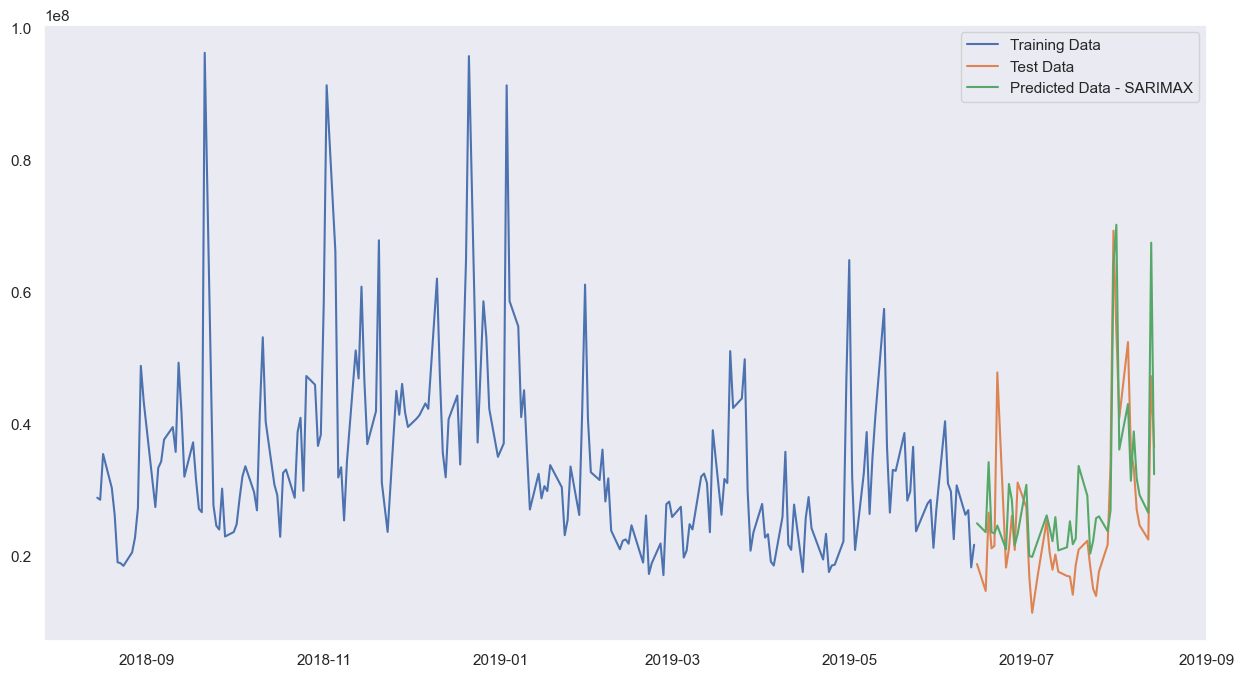

In [140]:
plt.plot(train_final, label = 'Training Data')
plt.plot(test_final, label = 'Test Data')
plt.plot(test_final.index, pred_SARIMAX.predicted_mean, 
         label = 'Predicted Data - SARIMAX')
plt.plot()
plt.legend(loc='best')
plt.grid()

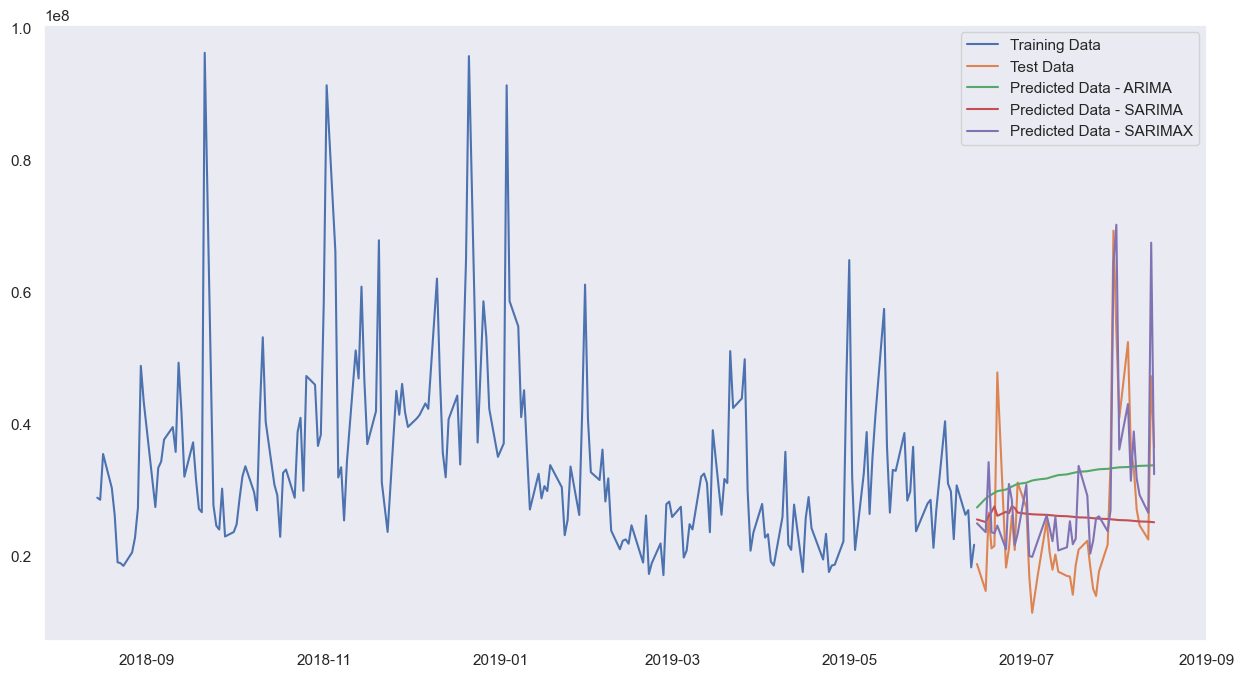

In [141]:
plt.plot(train_final, label = 'Training Data')
plt.plot(test_final, label = 'Test Data')
plt.plot(test_final.index, pred_ARIMA, 
         label = 'Predicted Data - ARIMA')
plt.plot(test_final.index, pred_SARIMA.predicted_mean, 
         label = 'Predicted Data - SARIMA')
plt.plot(test_final.index, pred_SARIMAX.predicted_mean, 
         label = 'Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.grid()